In [1]:
#Libraries imports
import torch
import edward
from edward.models import Categorical
import pandas as pd
#from sklearn.metrics import mean_squared_error
import time
import numpy as np
import random
import tensorflow as tf
import matplotlib as mpl
mpl.use('agg')
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#Load test data and necessary data for prediction inspection

with open('/home/yannis/Desktop/runs_icha_n24/2018-03-27 15:05:46_point_PDF.pt','rb') as f:
         probs = torch.load(f)
with open('../data/Wall/test_data_24sensors_1hot_scaled_30pc.pt','rb') as f:
      test_ = torch.load(f)



test_data = test_ 
N = len(test_data)


In [3]:
#Inspect posterior predictive distribution

y_post = []
n_samples = 5000


t0 = time.time()
for i in xrange(N):
    #print("Forming the posterior predictive distribution for test data point", i+1, "/", len(test_data), "...")
    y_post.append(Categorical(probs = probs[i]))

print("Took altogether", np.int(time.time() - t0), "secs.")

t0 = time.time()                                                                                                                                                                                                                                                                                                                                                                                                                                                            
print("Sampling the posterior predictive distribution for", len(test_data), "test data points...")
#posteriorsamplenodes = tf.stack([y_post[i].sample(n_samples) for i in range(N)], axis=1)
#Posterior samples contain n_samples samples from each posterior predictive distribution, shape = n_samples x N
psnodes = np.zeros((n_samples,N))
with tf.Session().as_default():
    for i in xrange(N):
        psnodes[:,i] = y_post[i].sample(n_samples).eval()
        
    posteriorsamples = pd.DataFrame(psnodes)
 
#print(posteriorsamples)
print("Took", np.int(time.time() - t0), "secs.")

('Took altogether', 6, 'secs.')
('Sampling the posterior predictive distribution for', 327, 'test data points...')
('Took', 136, 'secs.')


In [4]:
#Inspect prediction statistics

#Predictions are the mean over the #n_samples predicted values for each test data point
#predictions = posteriorsamples.mean()

mostCommonVote=[]
for i in xrange(N):
    votes, values = np.unique(psnodes[:,i], return_counts=True)
    if np.all(values<=1):
            mostCommonVote.append(psnodes[0,i])
    else:
        mostCommonVote.append( votes[np.argmax(values)] )
predictions = mostCommonVote

predictions_low = posteriorsamples.quantile(0.01)
predictions_high = posteriorsamples.quantile(0.99)

results = pd.DataFrame()
results['Bayesian_prediction'] = predictions    
results['Bayesian_prediction_low'] = predictions_low
results['Bayesian_prediction_high'] = predictions_high

#Results contain the accuracy of the predictions on the test data points
print("Accuracy on test data for Bayesian neural network:")
print(len(np.where(results['Bayesian_prediction']==np.argmax(test_data[:,24:28],axis=1))[0])/float(len(test_data[:,2]))*100)
#results

Accuracy on test data for Bayesian neural network:
66.9724770642


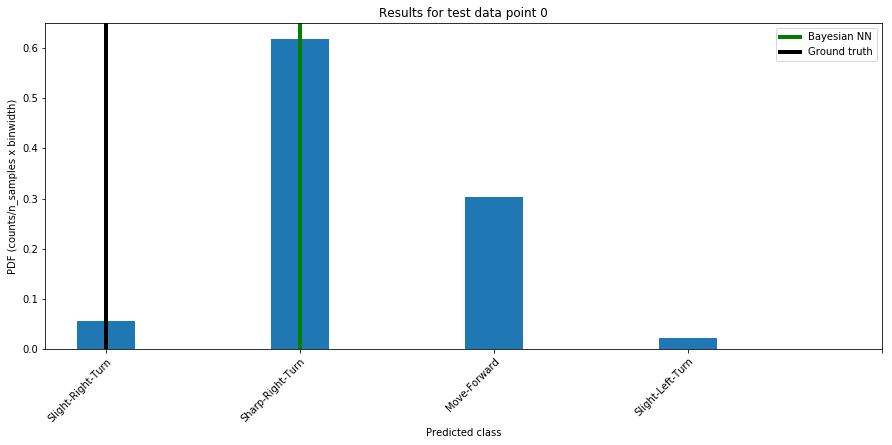

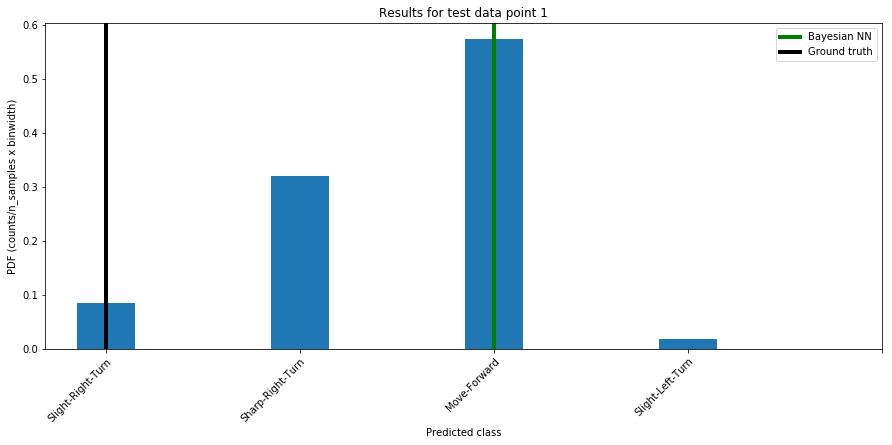

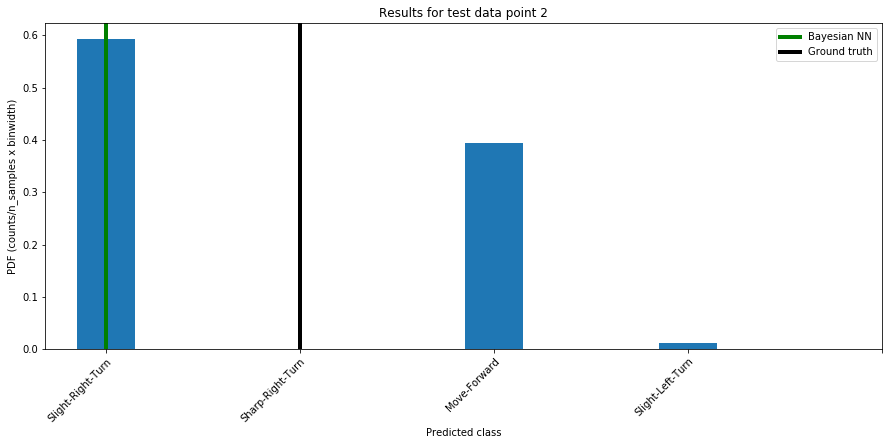

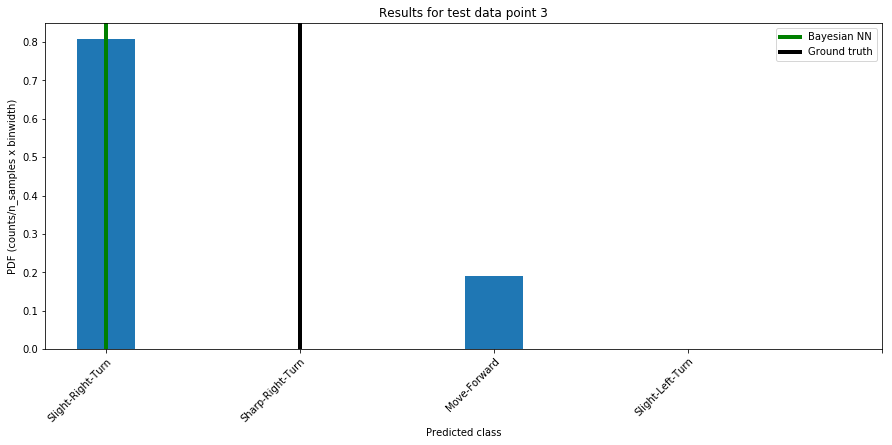

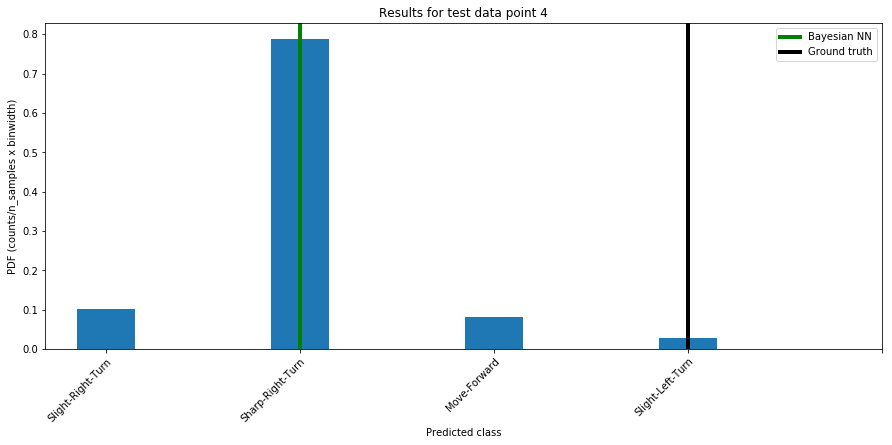

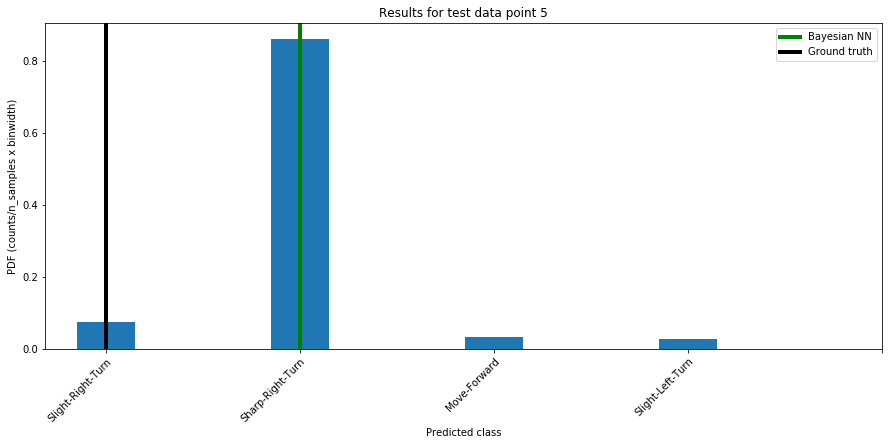

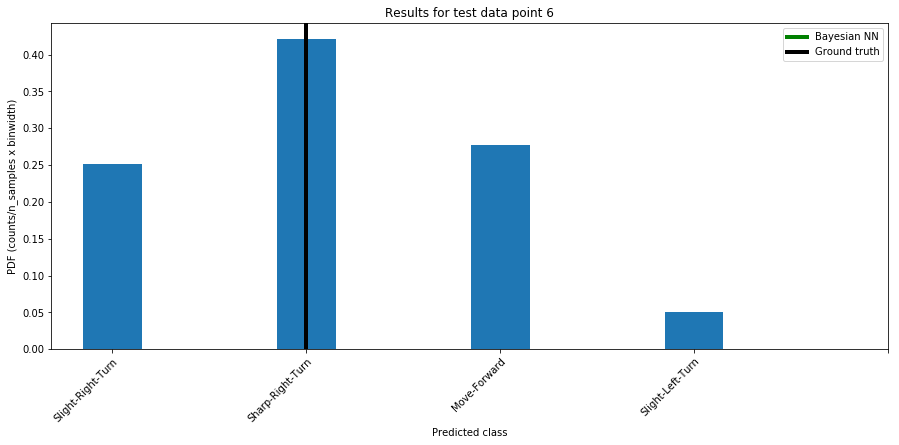

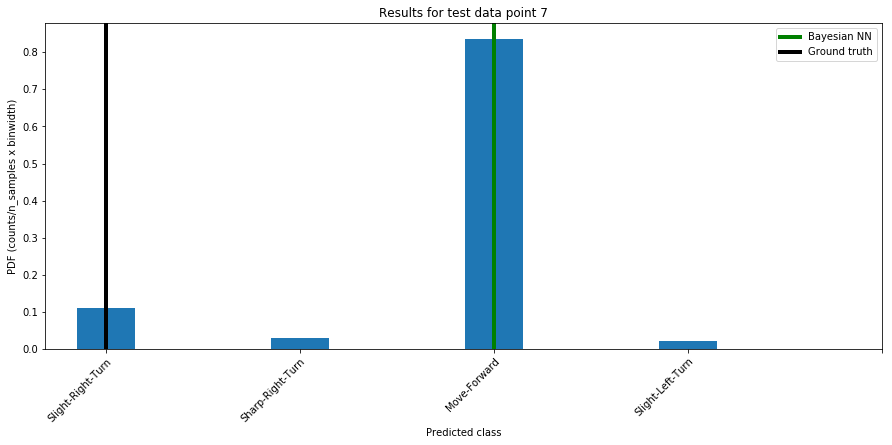

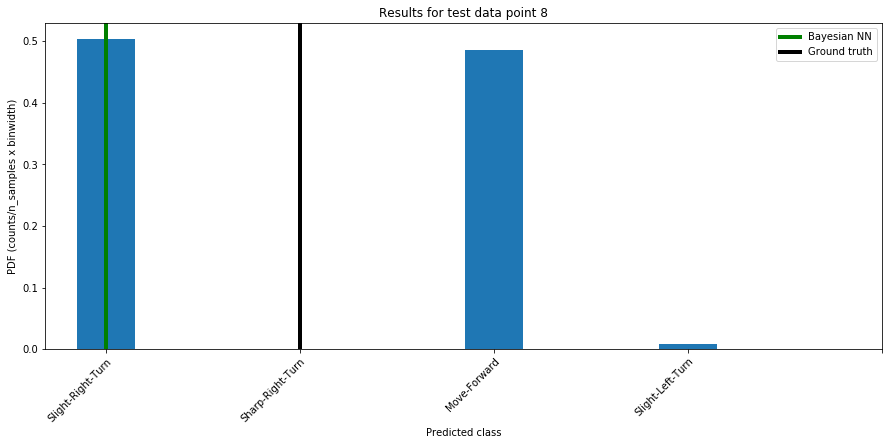

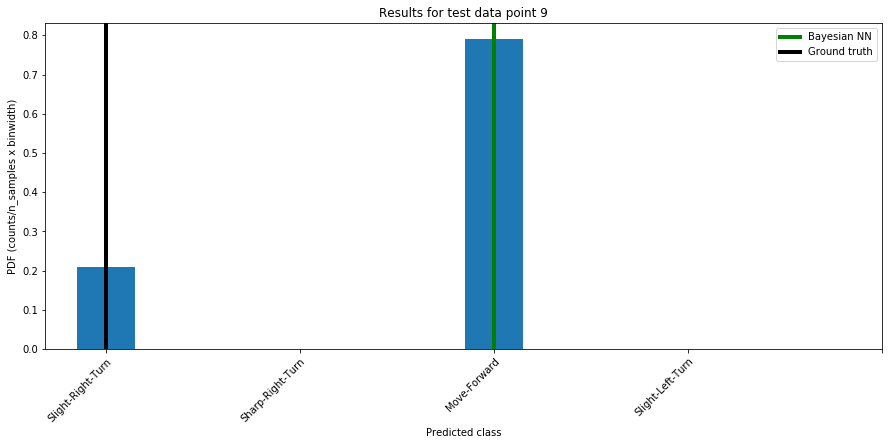

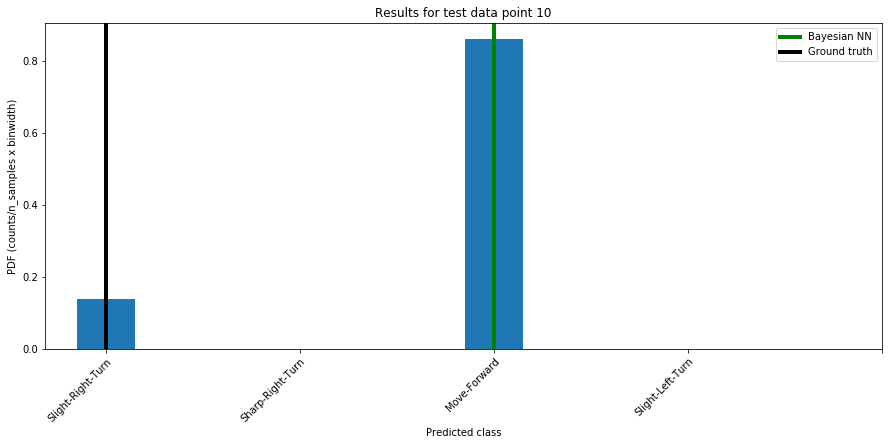

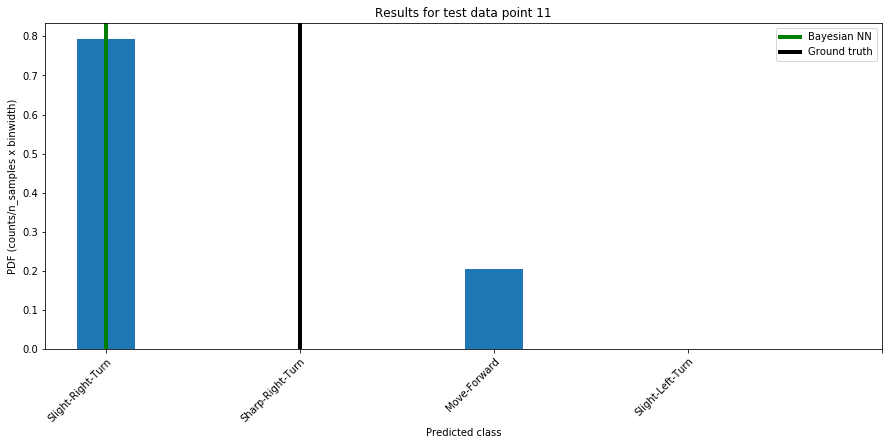

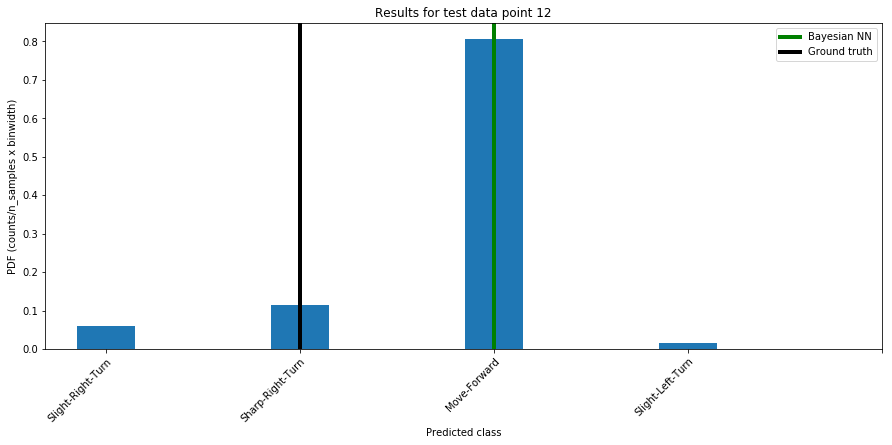

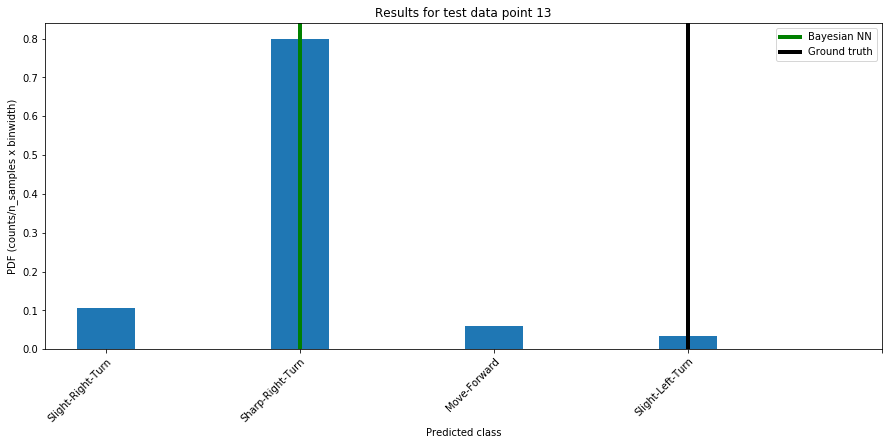

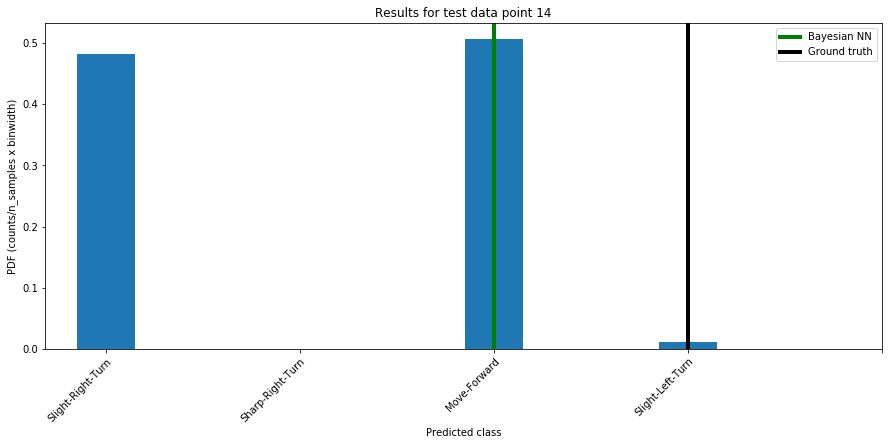

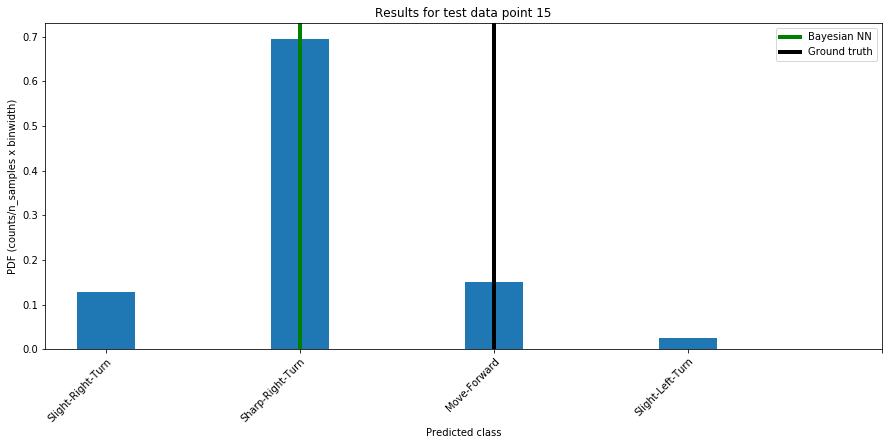

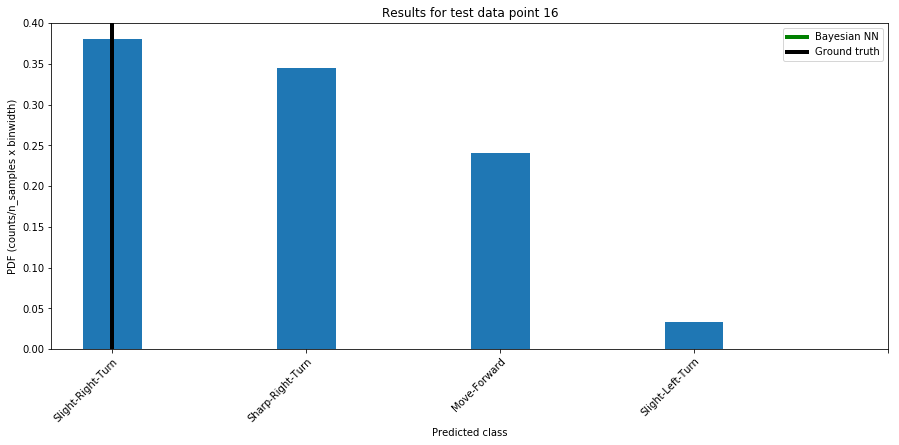

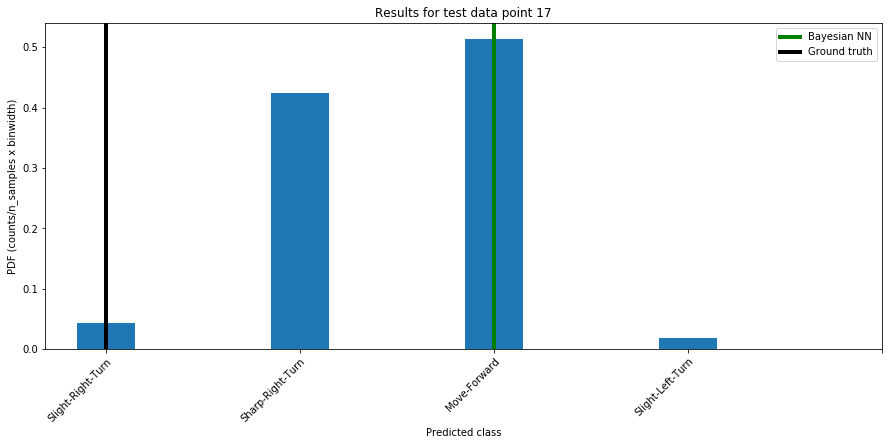

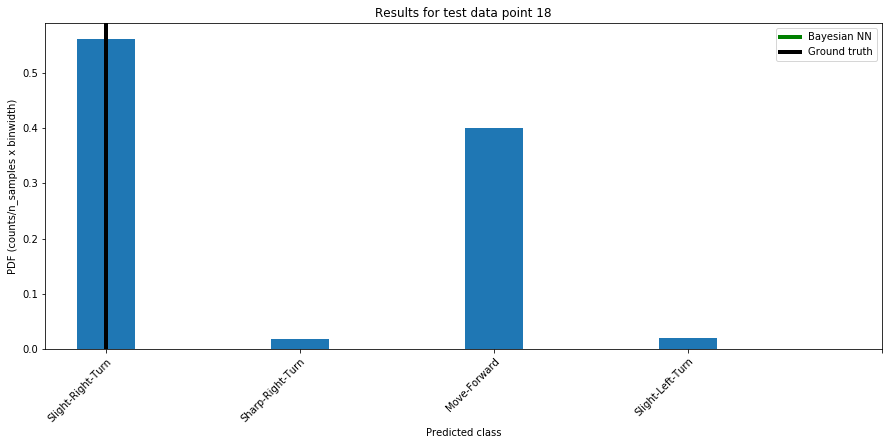

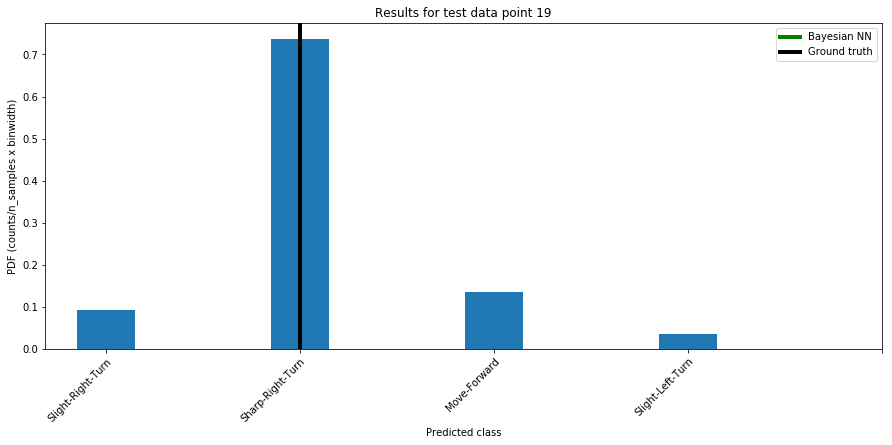

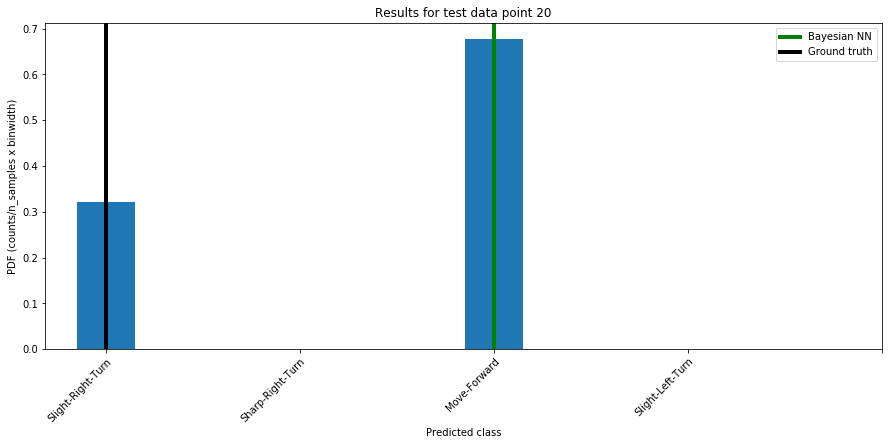

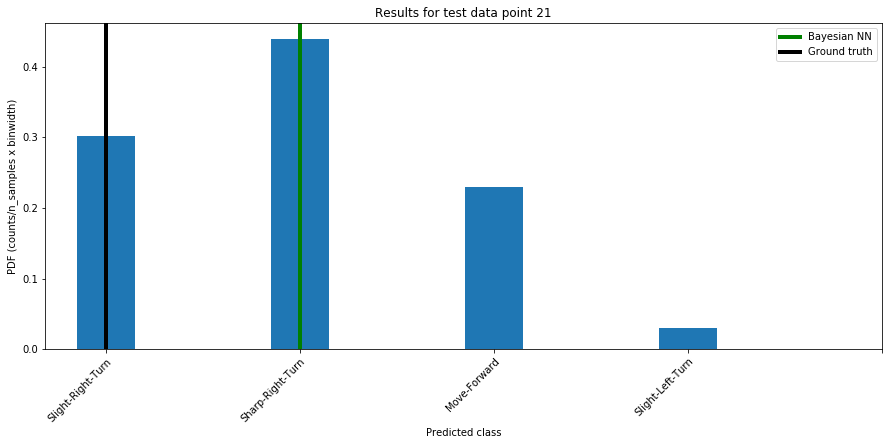

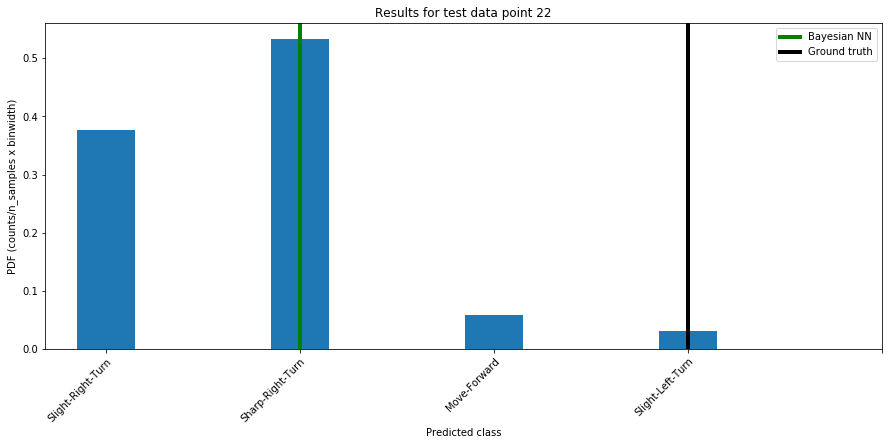

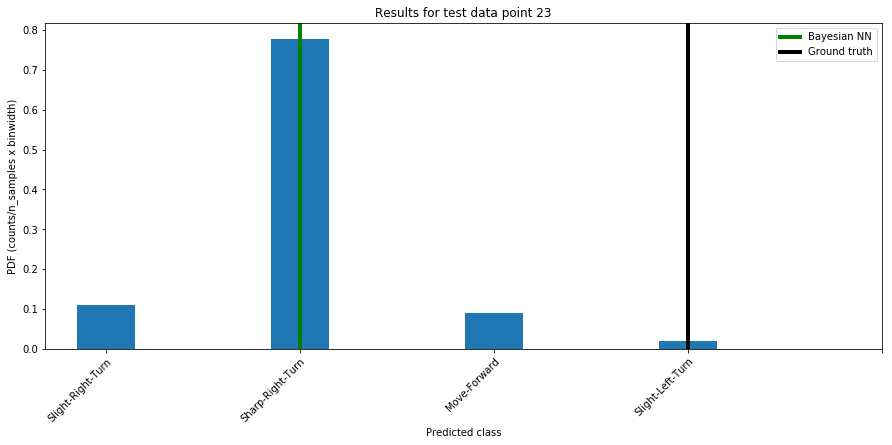

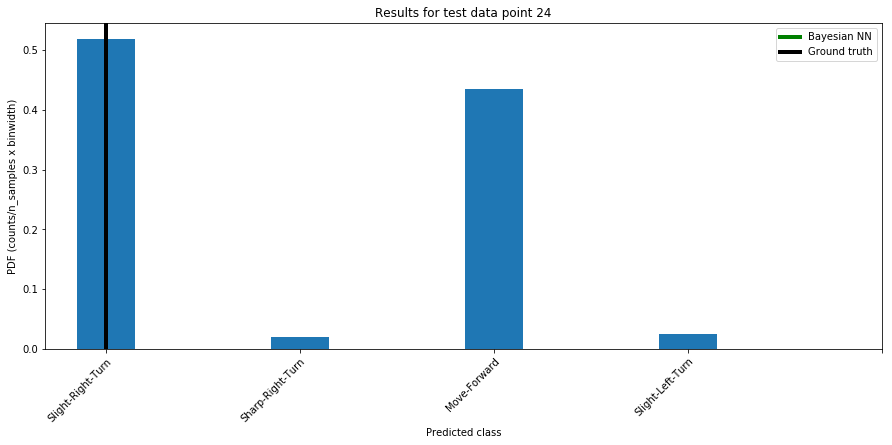

KeyboardInterrupt: 

In [10]:
#Visualise one (random) prediction and associated uncertainty
names = ['Slight-Right-Turn','Sharp-Right-Turn','Move-Forward','Slight-Left-Turn']
bins=[0,1,2,3,4]
#test_sample_number = np.random.choice(range(len(test_data)))
for i in xrange(len(test_data)):
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)
    test_sample_number = i
    
    _, _, histogram = plt.hist(posteriorsamples[test_sample_number].values, bins=bins, density=True, align='left',rwidth=0.3)
    plt.xlabel("Predicted class")
    plt.ylabel("PDF (counts/n_samples x binwidth)")
    plt.axvline(results.loc[test_sample_number, 'Bayesian_prediction'], color='g', linewidth=4, label="Bayesian NN")
    plt.axvline(np.argmax(test_data[test_sample_number,2:6]), color='k', linewidth=4, label="Ground truth")
    plt.legend()
    plt.title("Results for test data point " + str(test_sample_number))
    ax.set_xticks(bins)
    ax.set_xticklabels(names,rotation=45, rotation_mode="anchor", ha="right")
    plt.show()
    time.sleep(0.5)

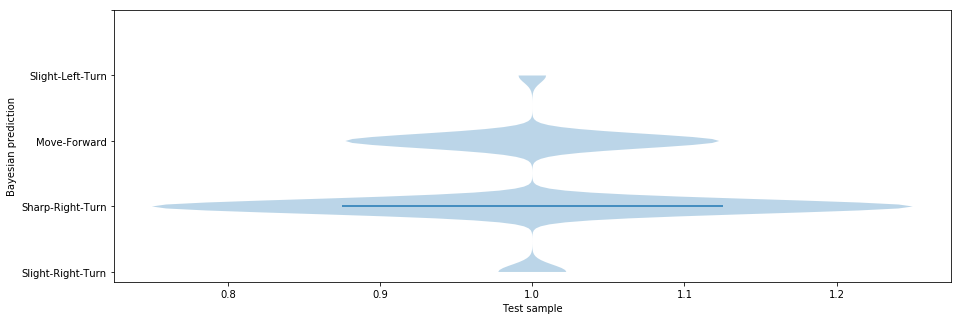

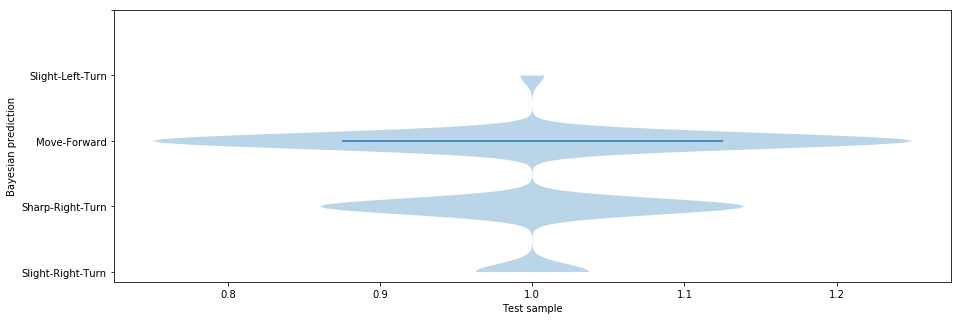

KeyboardInterrupt: 

In [15]:
for i in xrange(len(test_data)):
    fig = plt.figure(1, figsize=(15, 5))
    test_sample_number = i
    #Boxplot of predictions
    #ax = fig.add_subplot(111)
    #bp = ax.boxplot(psnodes[:,i])
    #plt.xlabel("Test sample")
    #plt.ylabel("Prediction")
    #Violin plot of predictions
    ax = fig.add_subplot(111) #(121)
    vp = ax.violinplot(psnodes[:,i], showmeans=False, showmedians=True, showextrema=False)
    
    ax.set_yticks(bins)
    ax.set_yticklabels(names)
    
    plt.xlabel("Test sample")
    plt.ylabel("Bayesian prediction")
    plt.show()
    time.sleep(0.5)

(-0.1, 2.1)


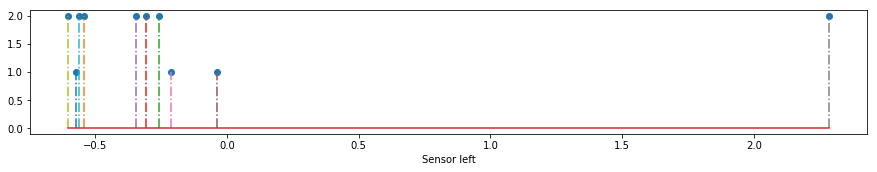

In [27]:
#Stem plot of predictions vs features
fig = plt.figure(1, figsize=(15, 5))
ax = fig.add_subplot(111)
markerline, stemlines, baseline = plt.stem(test_data[0:10,0], predictions[0:10], '-.')
plt.xlabel("Sensor front")
plt.ylabel("Prediction")

#fig = plt.figure(1, figsize=(15, 5))
ax = fig.add_subplot(211)
markerline, stemlines, baseline = plt.stem(test_data[0:10,1], predictions[0:10], '-.')
plt.xlabel("Sensor left")
ymin, ymax = plt.ylim()
plt.show()